In [13]:
# imports
from scipy import stats
from sirs import Sirs, SirsSolver
from utils import *

In [2]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
ONE_TIMES_ONE = (9,8)
TWO_TIMES_ONE = (20,8)
TWO_TIMES_TWO = (20,15)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=MEDIUM, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [143]:
dI

0.5333333333333333

(0.5044777633637082, 0.10089367182606199, 0.3946285648102298)
0.5054070991673663 0.1024227926805686 0.39217010815206516


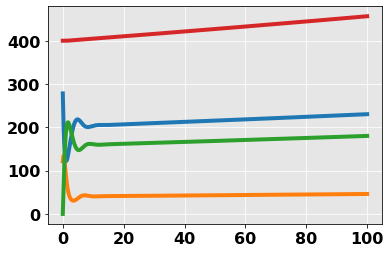

In [163]:
N0 = 400
I0 = 100
a = 4
b = 2
c = .5
d = .01
e = .012

alpha = c/a
beta = c+d+c/a*(b+d)
gamma = (d-e)*(b+c+s*d)

dI = (-1*beta + np.sqrt(beta**2 - 4*alpha*gamma))/(2*alpha)

i0 = (e-d)/dI


sirs = Sirs(N0, i0*N0, a=a, b=b, c=c, d=d, dI=dI, e=e)
solver = SirsSolver(sirs)
solver.run_rk4(t_max=100, n_iter=20000)
print(sirs.get_fractions())
print(s:=(b+d+dI)/(a-d), i:=(c+e-c*s)/(c+d+a*s), 1-s-i)

S, I, R, N = solver.get_fractions()
t_rk = solver.t
plt.plot(t_rk, S*N)
plt.plot(t_rk, I*N)
plt.plot(t_rk, R*N)

#plt.plot(t_rk, S)
#plt.plot(t_rk, I)
plt.plot(t_rk, N)

plt.show()

(b=1:n=6002), (b=2:n=12001), (b=3:n=18002), (b=4:n=24002), 

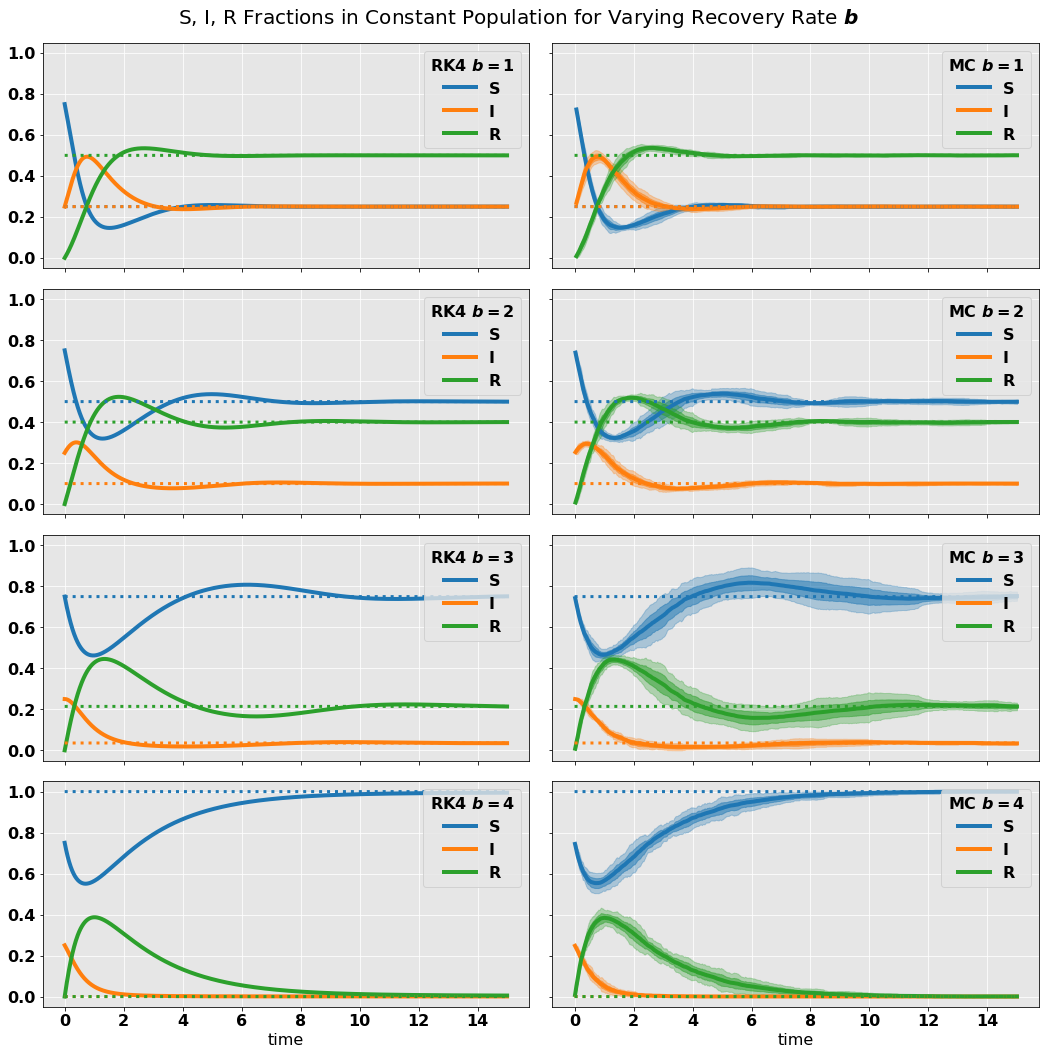

In [170]:
#%%timeit -r 1

N0 = 400
I0 = 100
a = 4
c = .5

t_end = 15
rk_steps = 100*t_end
mc_runs = 10
filter_length = 25
plot_const = True

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, sharey=True, figsize=(15,15))

fig.suptitle('S, I, R Fractions in Constant Population for Varying Recovery Rate $b$')
ax = axes[3,0]
ax.set_xlabel('time')

ax = axes[3,1]
ax.set_xlabel('time')

for j, b in enumerate((1,2,3,4)):
    ax = axes[j,0]
    sirs = Sirs(N0, I0, a=a, b=b, c=c)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end, rk_steps)
    S, I, R, _ = solver.get_fractions()
    t_rk = solver.t
    ax.plot(t_rk, S)
    ax.plot(t_rk, I)
    ax.plot(t_rk, R)
    ax.legend(['S', 'I', 'R'], title=f'RK4 $b={b}$', loc='upper right')
    if plot_const:
        s, i, r = sirs.constant_fractions()
        ax.plot(t_rk, np.zeros(rk_steps+1) + s, ':', color=COLORS[0], lw=3)
        ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[1], lw=3)
        ax.plot(t_rk, np.zeros(rk_steps+1) + r, ':', color=COLORS[2], lw=3)
        
    ax = axes[j,1]
    sirs_list = make_sirs_list(mc_runs, N0, I0, a=a, b=b, c=c)
    t_mc, series = mc_stats(sirs_list, seed=0, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]
    
    for k, P in enumerate(['S', 'I', 'R']):
        mu, sigma = series[P]
        mu = np.convolve(mu, np.ones(filter_length)/filter_length)
        sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)
        
        mu = mu[filter_rng]
        sigma = sigma[filter_rng]
        
        t_alpha = stats.t.ppf(.99, mc_runs-1)
        upper = mu + t_alpha*sigma
        upper[upper > 1] = 1
        lower = mu - t_alpha*sigma
        lower[lower < 0] = 0
        ax.fill_between(t_mc, lower, upper, color=COLORS[k], alpha=.3)  # CI99 interval
        
        t_alpha = stats.t.ppf(.90, mc_runs-1)
        upper = mu + t_alpha*sigma
        upper[upper > 1] = 1
        lower = mu - t_alpha*sigma
        lower[lower < 0] = 0
        ax.fill_between(t_mc, lower, upper, color=COLORS[k], alpha=.5)  # CI90 interval
        
        ax.plot(t_mc, mu, color=COLORS[k])
    
    ax.legend(['S', 'I', 'R'], title=f'MC $b={b}$', loc='upper right')
    
    if plot_const:
        s, i, r = sirs.constant_fractions()
        ax.plot(t_rk, np.zeros(rk_steps+1) + s, ':', color=COLORS[0], lw=3)
        ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[1], lw=3)
        ax.plot(t_rk, np.zeros(rk_steps+1) + r, ':', color=COLORS[2], lw=3)
    
    print(f'(b={b}:n={len(t_mc)+filter_length}),', end=' ')
        
plt.tight_layout()
plt.show()

(dI=0.00:n=351898), (dI=1.00:n=233828), (dI=5.00:n=1035040), 

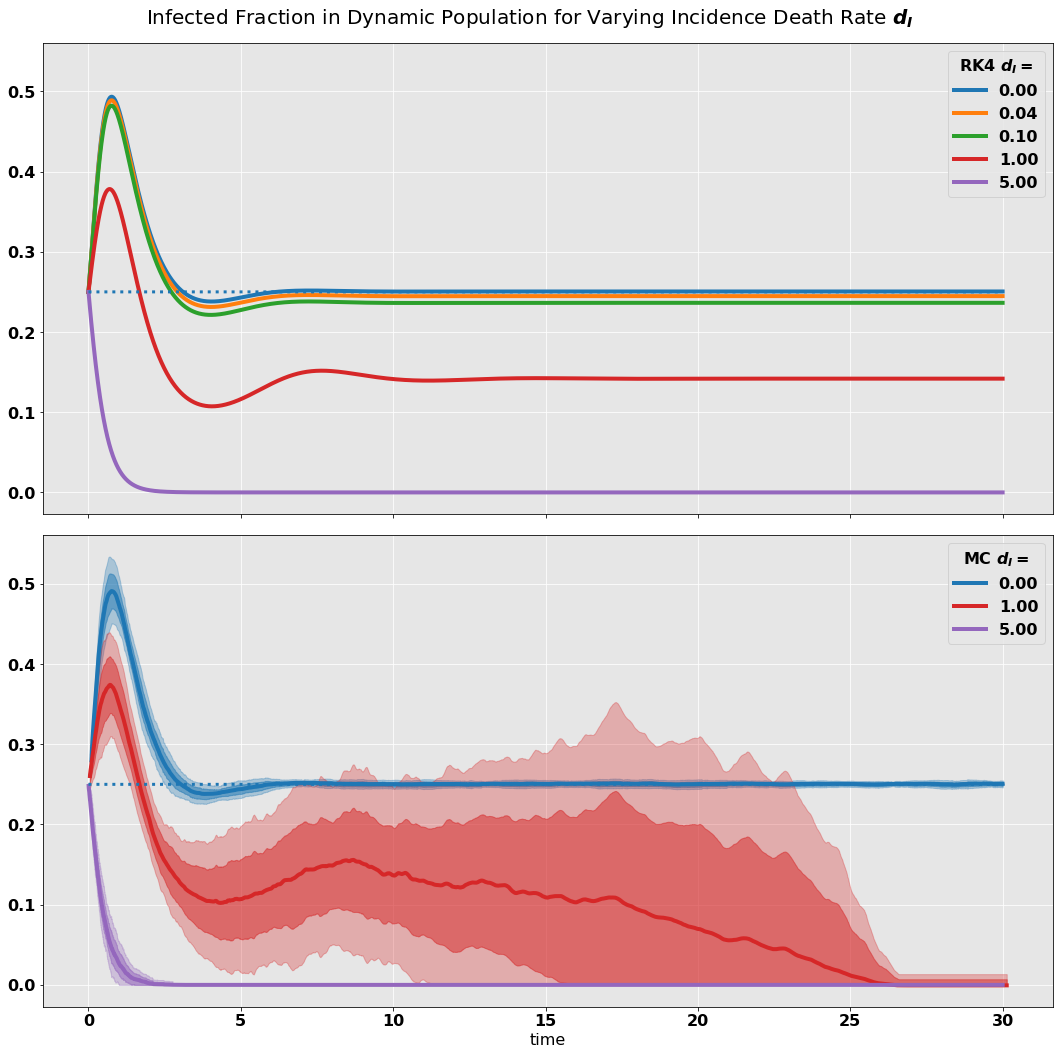

In [254]:
N0 = 400
I0 = 100
a = 4
b = 1
c = .5
d = .001
e = .002

t_end = 30
rk_steps = 100*t_end

fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=(15,15))

fig.suptitle('Infected Fraction in Dynamic Population for Varying Incidence Death Rate $d_I$')
ax = axes[1]
ax.set_xlabel('time')

#ax = axes[3,1]
#ax.set_xlabel('time')

dI_range = np.arange(.0,3.6,.6)
dI_range = [0., 0.0401, .1, 1., 5.]

j = -1
for dI in dI_range:
    j += 1
    ax = axes[0]
    sirs = Sirs(N0, I0, a=a, b=b, c=c, d=d, e=e, dI=dI)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end, rk_steps)
    _, I, _, N = solver.get_fractions()
    t_rk = solver.t
    ax.plot(t_rk, I)

    ax = axes[1]
    if dI not in [0., 1., 5.]:
        continue

    mc_runs = 30
    filter_length = 100
    if dI == 1.:
        filter_length = 1000
        mc_runs = 100

    sirs_list = make_sirs_list(mc_runs, N0, I0, a=a, b=b, c=c, d=d, e=e, dI=dI)
    t_mc, series = mc_stats(sirs_list, seed=0, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]
    
    mu, sigma = series['I']
    mu = np.convolve(mu, np.ones(filter_length)/filter_length)
    sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)

    mu = mu[filter_rng]
    sigma = sigma[filter_rng]

    t_alpha = stats.t.ppf(.99, mc_runs-1)
    upper = mu + t_alpha*sigma
    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma
    lower[lower < 0] = 0
    upper[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.3, color=COLORS[j])  # CI99 interval

    t_alpha = stats.t.ppf(.90, mc_runs-1)
    upper = mu + t_alpha*sigma
    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma
    lower[lower < 0] = 0
    upper[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.5, color=COLORS[j])  # CI90 interval

    ax.plot(t_mc, mu, color=COLORS[j])
   
    print(f'(dI={dI:.2f}:n={len(t_mc)+filter_length}),', end=' ')


ax = axes[0]
_, i, _ = sirs.constant_fractions()
ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[0], lw=3)
ax.legend([f'{dI_val:.2f}' for dI_val in dI_range], title=f'RK4 $d_I=$', loc='upper right')
ax = axes[1]
ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[0], lw=3)
ax.legend([f'{dI_val:.2f}' for dI_val in [0., 1., 5.]], title=f'MC $d_I=$', loc='upper right')


plt.tight_layout()
plt.show()

(dI=0.00:n=678476), (dI=0.04:n=392178), (dI=0.10:n=208039), (dI=1.00:n=47588), (dI=5.00:n=1901158), 

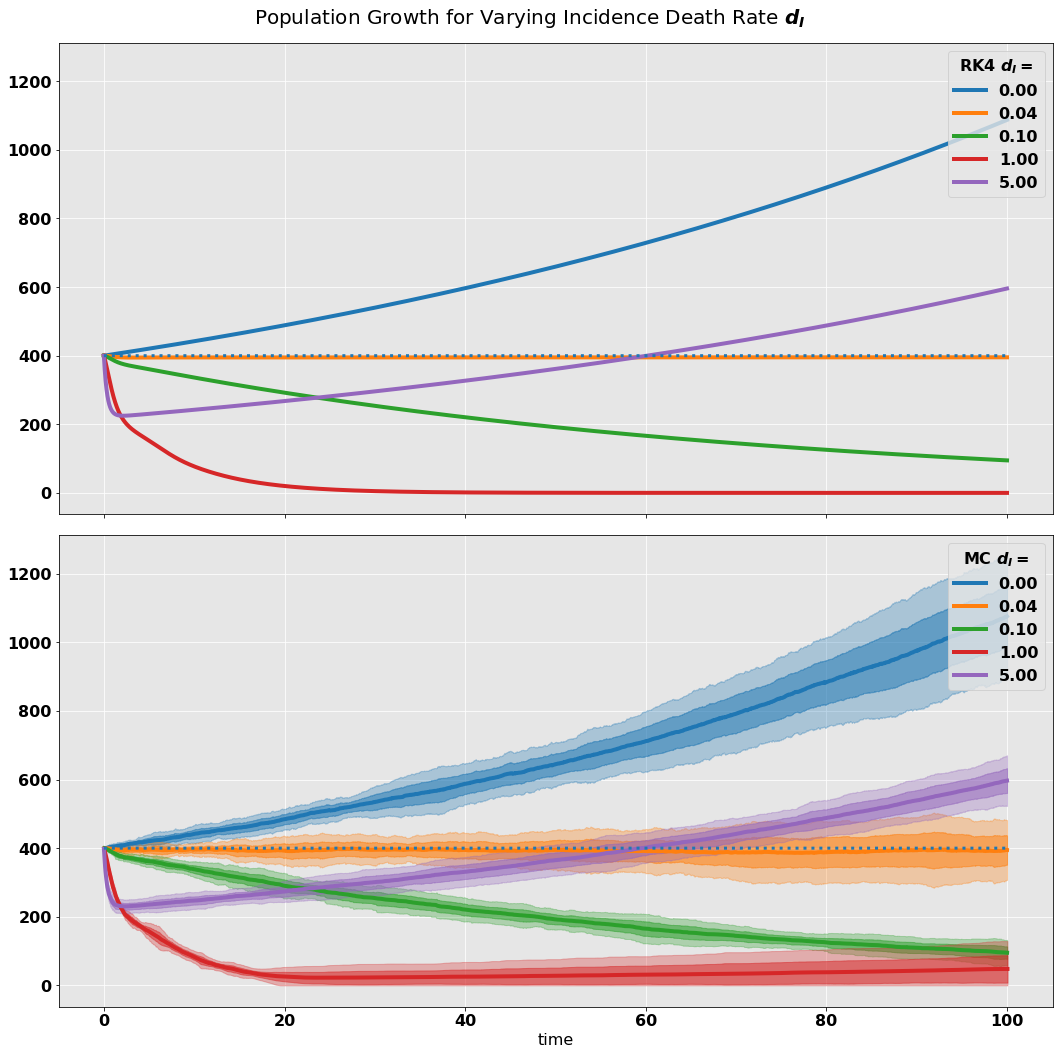

In [260]:
N0 = 400
I0 = 100
a = 4
b = 1
c = .5
d = .01
e = .02

t_end = 100
rk_steps = 100*t_end
filter_length = 1000

fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=(15,15))

fig.suptitle('Population Growth for Varying Incidence Death Rate $d_I$')
ax = axes[1]
ax.set_xlabel('time')

#ax = axes[3,1]
#ax.set_xlabel('time')

dI_range = [0., 0.0401, .1, 1., 5.]

j = -1
for dI in dI_range:
    j += 1
    ax = axes[0]
    sirs = Sirs(N0, I0, a=a, b=b, c=c, d=d, e=e, dI=dI)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end, rk_steps)
    _, I, _, N = solver.get_fractions()
    t_rk = solver.t
    ax.plot(t_rk, N)
    
    ax = axes[1]
   
    mc_runs = 10
    filter_length = 100
#    if dI == 1.:
#        filter_length = 1000
#        mc_runs = 100
    
    sirs_list = make_sirs_list(mc_runs, N0, I0, a=a, b=b, c=c, d=d, e=e, dI=dI)
    t_mc, series = mc_stats(sirs_list, seed=0, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]
    
    mu, sigma = series['N']
    mu = np.convolve(mu, np.ones(filter_length)/filter_length)
    sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)

    mu = mu[filter_rng]
    sigma = sigma[filter_rng]

    t_alpha = stats.t.ppf(.99, mc_runs-1)
    upper = mu + t_alpha*sigma
#    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma
    lower[lower < 0] = 0
    upper[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.3, color=COLORS[j])  # CI99 interval

    t_alpha = stats.t.ppf(.90, mc_runs-1)
    upper = mu + t_alpha*sigma
#    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma
    lower[lower < 0] = 0
    upper[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.5, color=COLORS[j])  # CI90 interval

    ax.plot(t_mc, mu, color=COLORS[j])
   
    print(f'(dI={dI:.2f}:n={len(t_mc)+filter_length}),', end=' ')


ax = axes[0]
_, i, _ = sirs.constant_fractions()
ax.legend([f'{dI_val:.2f}' for dI_val in dI_range], title=f'RK4 $d_I=$', loc='upper right')
ax.plot(t_rk, np.zeros(rk_steps+1) + N0, ':', color=COLORS[0], lw=3)
ax = axes[1]
ax.legend([f'{dI_val:.2f}' for dI_val in dI_range], title=f'MC $d_I=$', loc='upper right')
ax.plot(t_rk, np.zeros(rk_steps+1) + N0, ':', color=COLORS[0], lw=3)

plt.tight_layout()
plt.show()

In [97]:
N0 = 400
I0 = 100
A = 0
a = 4
b = 1
c = 1
e = .0
d = .0
dI = .0
F = .0
f = .1
sirs = Sirs(N0, I0, A=A, a=a, b=b, c=c, e=e, d=d, dI=dI, F=F, f=f)
solver = SirsSolver(sirs)
solver.run_mc(t_max=10000)

In [98]:
stats, (S,I,R,N) = solver.get_stats(5)

<BarContainer object of 11 artists>

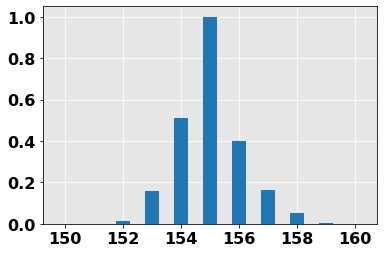

In [101]:
mu, sigma = stats['R']
y, x = np.histogram(R, bins=11, range=(mu-5*sigma, mu+5*sigma))
plt.bar(np.arange(-5,6)+int(mu), y/y.max(), width=.5, align='center')
#plt.xlim(-5.5,5.5)

In [117]:
N0 = 400
I0 = 100
A = 2
a = 4
b = 2
c = 1
e = .012
d = .008
dI = .1
F = .0
f = 0

fa = (lambda t: bathtub(t, .1, floor=.6, delay=5, duration=2)*seasonal_variation(t, a=4, A=2, shift=3))

n = 10
t_max = 50
sirs_list = make_sirs_list(n, N0, I0, A=A, a=a, b=b, c=c, e=e, d=d, dI=dI, F=F, f=f, fa=fa)
t, series = mc_stats(sirs_list, seed=0, t_max=t_max)

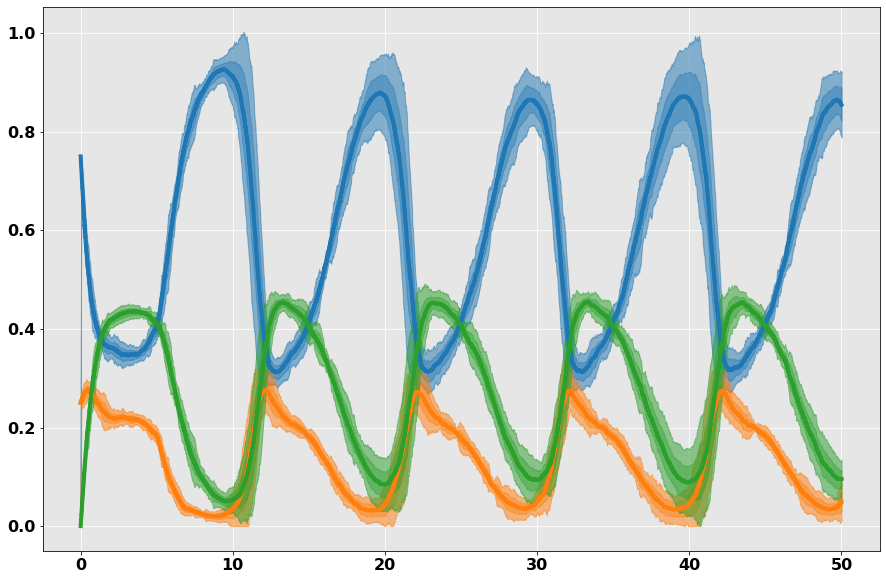

In [118]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(15,10))

ax = axes

filter_length = 100

for i, P in enumerate(['S', 'I', 'R']):
    mu, sigma = series[P]
    ax.plot(t, mu, color=COLORS[i])

    mu = np.convolve(mu, np.ones(filter_length))[:-1*(filter_length-1)]/filter_length
    sigma = np.convolve(sigma, np.ones(filter_length))[:-1*(filter_length-1)]/filter_length
    t_alpha = scipy.stats.t.ppf(.90, n-1)
    upper = mu + t_alpha*sigma
    lower = mu - t_alpha*sigma
    lower[lower < 0] = 0
    ax.fill_between(t, lower, upper, color=COLORS[i], alpha=.4)
    t_alpha = scipy.stats.t.ppf(.99, n-1)
    upper = mu + t_alpha*sigma
    lower = mu - t_alpha*sigma
    lower[lower < 0] = 0
    ax.fill_between(t, lower, upper, color=COLORS[i], alpha=.5)

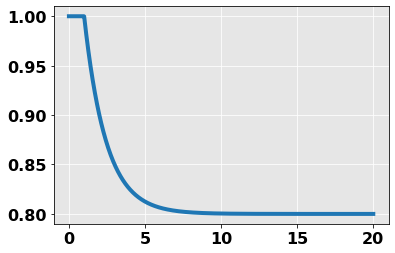

In [95]:
plt.plot(x:=np.linspace(0,20,1000), [exponential_decay(xi, 1, floor=.8, delay=1) for xi in x])

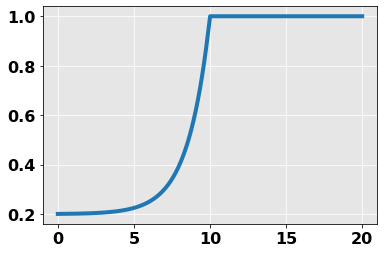

In [97]:
plt.plot(x:=np.linspace(0,20,1000), [exponential_growth(xi, 1, floor=.2, delay=10) for xi in x])

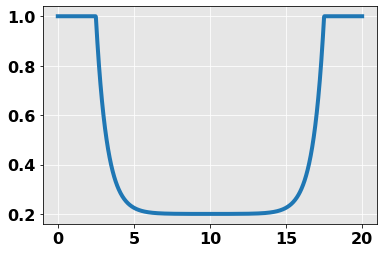

In [102]:
plt.plot(x:=np.linspace(0,20,1000), [bathtub(xi, .5, floor=.2, delay=2.5, duration=15) for xi in x])

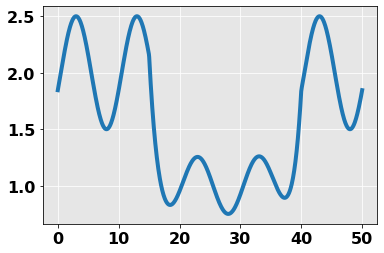

In [108]:
fa = (lambda t: bathtub(t, 1, floor=.5, delay=15, duration=25)*seasonal_variation(t, a=2, shift=3))
plt.plot(x:=np.linspace(0,50,1000), [fa(xi) for xi in x])